In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import chisquare
from scipy.stats import kruskal
import scikit_posthocs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
df = pd.read_excel(r"C:\Users\rayde\Desktop\DSI_kickstarterscrape_dataset.xlsx", parse_dates=['funded date'])

In [4]:
df.columns

Index(['project id', 'name', 'url', 'category', 'subcategory', 'location',
       'status', 'goal', 'pledged', 'funded percentage', 'backers',
       'funded date', 'levels', 'reward levels', 'updates', 'comments',
       'duration'],
      dtype='object')

In [5]:
df.describe()

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.080800e+09,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,6.218057e+08,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,5.438962e+08,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,1.078345e+09,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,1.621596e+09,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


## Browse Duplicates

In [6]:
bool_filter = df['project id'].duplicated() == True
values = list(df['project id'][bool_filter].values)
df[df['project id'].isin(values)].sort_values('project id')

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
45651,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45652,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45653,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45654,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45655,2140513451,The Cookie Chew - Changing the Way We Eat a Co...,http://www.kickstarter.com/projects/1650956569...,Food,Food,"San Diego, CA",successful,4500.0,5540.0,1.231111,89,2010-08-24 04:43:00+00:00,5,"$10,$50,$75,$100,$500",14,17,43.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45930,2146435917,Making Mama(s) Proud: The 2011 &quot;Donna/Mad...,http://www.kickstarter.com/projects/johnpaulka...,Theater,Theater,"Los Angeles, CA",successful,5000.0,5390.0,1.078000,86,2011-06-04 08:56:58+00:00,8,"$1,$10,$25,$50,$100,$200,$500,$1,000",5,1,30.00
45931,2146437406,The Production of Erasure,http://www.kickstarter.com/projects/295025953/...,Photography,Photography,"Brooklyn, NY",successful,1200.0,1220.0,1.016667,17,2011-03-03 04:09:38+00:00,6,"$15,$25,$50,$100,$200,$500",1,0,30.00
45932,2146437406,The Production of Erasure,http://www.kickstarter.com/projects/295025953/...,Photography,Photography,"Brooklyn, NY",successful,1200.0,1220.0,1.016667,17,2011-03-03 04:09:38+00:00,6,"$15,$25,$50,$100,$200,$500",1,0,30.00
45933,2146534146,CALLING on ANGELS - not FOR KIDS ONLY!,http://www.kickstarter.com/projects/callingona...,Film &amp; Video,Film &amp; Video,"Burbank, CA",failed,10000.0,250.0,0.025000,1,2011-09-10 19:00:47+00:00,11,"$10,$25,$50,$75,$100,$150,$250,$500,$1,000,$1,...",0,0,60.00


In [7]:
df[df['project id'].duplicated(keep=False)].sort_values(by='project id').head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
45651,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45652,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45653,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45654,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45655,2140513451,The Cookie Chew - Changing the Way We Eat a Co...,http://www.kickstarter.com/projects/1650956569...,Food,Food,"San Diego, CA",successful,4500.0,5540.0,1.231111,89,2010-08-24 04:43:00+00:00,5,"$10,$50,$75,$100,$500",14,17,43.27


## Drop Duplicates on Project Id / Drop Cancelled or Live Projects

In [8]:
new_df = df.drop_duplicates(subset=['project id'])
new_df = new_df.query('status == "successful" | status =="failed"')

In [9]:
new_df['status'].unique()

array(['successful', 'failed'], dtype=object)

## Fix inconsistent data entry / importation errors

In [10]:
new_df.subcategory.unique()

array(['Short Film', 'Board & Card Games', 'Documentary', 'Fashion',
       'Music', 'Illustration', 'Open Software', 'Indie Rock', 'Dance',
       'Fiction', 'Nonfiction', 'Film &amp; Video', 'Theater', 'Games',
       'Art Book', 'Animation', 'Country & Folk', 'Comics', 'Webseries',
       'Technology', 'Performance Art', 'Narrative Film', 'Video Games',
       'Product Design', 'Painting', 'Photography', 'Conceptual Art',
       'Rock', 'Jazz', 'Classical Music', 'Food', 'Art', 'Pop',
       'Journalism', 'Poetry', 'World Music', 'Sculpture', 'Publishing',
       'Electronic Music', "Children's Book", 'Open Hardware',
       'Graphic Design', 'Hip-Hop', 'Public Art', 'Mixed Media',
       'Periodical', 'Crafts', 'Design', 'Digital Art',
       'Board &amp; Card Games', 'Country &amp; Folk'], dtype=object)

In [11]:
new_df.category.unique()

array(['Film & Video', 'Games', 'Fashion', 'Music', 'Art', 'Technology',
       'Dance', 'Publishing', 'Theater', 'Comics', 'Design',
       'Photography', 'Food', 'Film &amp; Video'], dtype=object)

In [12]:
new_df = new_df.replace(to_replace="Film &amp; Video", value="Film & Video")
new_df = new_df.replace(to_replace='Board &amp; Card Games', value="Board & Card Games")
new_df = new_df.replace(to_replace='Country &amp; Folk', value="Country & Folk")

In [13]:
new_df.subcategory.unique()

array(['Short Film', 'Board & Card Games', 'Documentary', 'Fashion',
       'Music', 'Illustration', 'Open Software', 'Indie Rock', 'Dance',
       'Fiction', 'Nonfiction', 'Film & Video', 'Theater', 'Games',
       'Art Book', 'Animation', 'Country & Folk', 'Comics', 'Webseries',
       'Technology', 'Performance Art', 'Narrative Film', 'Video Games',
       'Product Design', 'Painting', 'Photography', 'Conceptual Art',
       'Rock', 'Jazz', 'Classical Music', 'Food', 'Art', 'Pop',
       'Journalism', 'Poetry', 'World Music', 'Sculpture', 'Publishing',
       'Electronic Music', "Children's Book", 'Open Hardware',
       'Graphic Design', 'Hip-Hop', 'Public Art', 'Mixed Media',
       'Periodical', 'Crafts', 'Design', 'Digital Art'], dtype=object)

In [14]:
new_df.category.unique()

array(['Film & Video', 'Games', 'Fashion', 'Music', 'Art', 'Technology',
       'Dance', 'Publishing', 'Theater', 'Comics', 'Design',
       'Photography', 'Food'], dtype=object)

In [15]:
new_df['name'] = new_df.name.str.replace("&quot;", '"')

In [16]:
new_df.name.iloc[4]

'Dinner Party - a short film about friendship... and revenge'

## Create new features out of funded date and location

In [17]:
new_df['duration_td'] = new_df.duration.apply(lambda x: datetime.timedelta(days=x))
new_df[['duration','duration_td']].dtypes

duration               float64
duration_td    timedelta64[ns]
dtype: object

In [18]:
new_df['Posting_Date'] = new_df['funded date'] - new_df['duration_td']
new_df[['Posting_Date','duration','duration_td', 'funded date']].head()

,Posting_Date,duration,duration_td,funded date
0,2011-07-20 19:28:17+00:00,30.00,30 days 00:00:00,2011-08-19 19:28:17+00:00
1,2010-06-15 23:39:48+00:00,47.18,47 days 04:19:12,2010-08-02 03:59:00+00:00
3,2012-03-06 20:57:12+00:00,32.22,32 days 05:16:48,2012-04-08 02:14:00+00:00
4,2011-05-02 15:25:39+00:00,30.00,30 days 00:00:00,2011-06-01 15:25:39+00:00
5,2011-06-01 03:13:48+00:00,21.43,21 days 10:19:12,2011-06-22 13:33:00+00:00


In [19]:
new_df['year'] = new_df['Posting_Date'].dt.year
new_df['month'] = new_df['Posting_Date'].dt.month
new_df['day'] = new_df['Posting_Date'].dt.day
new_df['time'] = new_df['Posting_Date'].dt.time
new_df['day of week'] = new_df['Posting_Date'].dt.dayofweek
new_df[['year','month', 'day', 'time', 'day of week']]

,year,month,day,time,day of week
0,2011,7,20,19:28:17,2
1,2010,6,15,23:39:48,1
3,2012,3,6,20:57:12,1
4,2011,5,2,15:25:39,0
5,2011,6,1,03:13:48,2
...,...,...,...,...,...
45952,2012,2,21,18:01:48,1
45953,2012,2,22,03:09:46,2
45954,2011,12,19,21:19:12,0
45955,2012,4,19,19:44:47,3


In [20]:
new_df['city'], new_df['state'] = new_df['location'].str.split(', ', 1).str
new_df[['city', 'state', 'location']]

,city,state,location
0,Columbia,MO,"Columbia, MO"
1,Maplewood,NJ,"Maplewood, NJ"
3,Los Angeles,CA,"Los Angeles, CA"
4,Novi,MI,"Novi, MI"
5,Portland,OR,"Portland, OR"
...,...,...,...
45952,Austin,TX,"Austin, TX"
45953,Los Angeles,CA,"Los Angeles, CA"
45954,Los Angeles,CA,"Los Angeles, CA"
45955,Vero Beach,FL,"Vero Beach, FL"


In [21]:
new_df['city'].unique()

array(['Columbia', 'Maplewood', 'Los Angeles', ..., 'Peaks',
       'Lumberville', 'Lake Oswego'], dtype=object)

In [22]:
new_df['state'].unique()

array(['MO', 'NJ', 'CA', 'MI', 'OR', 'TN', 'IL', nan, 'NY', 'DC', 'ID',
       'FL', 'TX', 'CO', 'ME', 'Taiwan', 'IN', 'Norway', 'MN', 'NC', 'MA',
       'PA', 'CT', 'Chile', 'MD', 'HI', 'VA', 'WA', 'AZ', 'OH', 'NV',
       'Haiti', 'GA', 'AL', 'UT', 'Canada', 'LA', 'SC', 'Ecuador', 'WI',
       'Jamaica', 'Argentina', 'Hong Kong', 'Germany', 'NM', 'NE',
       'Guatemala', 'IA', 'WY', 'Australia', 'RI', 'Sweden', 'OK', 'DE',
       'South Africa', 'AK', 'WV', 'Nepal', 'MT', 'KY', 'VT', 'Kenya',
       'Bosnia and Herzegovina', 'Iceland', 'Mexico', 'KS', 'Hungary',
       'Indonesia', 'China', 'SD', 'Cuba', 'Peru', 'Italy', 'Netherlands',
       'Singapore', 'Ethiopia', 'NH', 'New Zealand', 'France',
       'United Kingdom', 'Austria', 'Turkey', 'AR', 'Mt', 'Congo',
       'Colombia', 'India', 'Mongolia', 'MS', 'Israel', 'Dominica',
       'Finland', 'Czech Republic', 'Japan', 'Virgin Islands, U.S.',
       'Lebanon', 'Armenia', 'Portugal', 'Qatar', 'Morocco', 'Martinique',
       'Pue

In [23]:
new_df = new_df.replace(to_replace='Virginia', value="VA")

In [24]:
x, y = new_df[new_df.state == 'Middleburg, MD']['state'].str.split(', ', 1).str
row_val = list(new_df[new_df.state == 'Middleburg, MD'].index)[0]

new_df.loc[[row_val],['city']] = x
new_df.loc[[row_val], ['state']]= y
new_df.loc[row_val]

project id                                                  1637912974
name                                                        Light Ball
url                  http://www.kickstarter.com/projects/819627388/...
category                                                    Technology
subcategory                                                 Technology
location                                            10, Middleburg, MD
status                                                          failed
goal                                                             19500
pledged                                                            103
funded percentage                                           0.00528205
backers                                                              3
funded date                                  2012-03-31 03:59:00+00:00
levels                                                               6
reward levels                         $25,$100,$200,$750,$2,000,$3,500
update

In [25]:
new_df['country'] = new_df['state'].replace(to_replace=r'^..{1}$', value="USA", regex=True)
new_df[new_df.country != 'USA'].head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,...,duration_td,Posting_Date,year,month,day,time,day of week,city,state,country
11,727286,Offline Wikipedia iPhone app,http://www.kickstarter.com/projects/dphiffer/o...,Technology,Open Software,NaN,successful,99.0,145.0,1.464646,...,79 days 15:21:36,2009-04-25 15:38:23+00:00,2009,4,25,15:38:23,5,NaN,NaN,NaN
14,893085,Esperanza Farm: A Novel,http://www.kickstarter.com/projects/JesusMaria...,Publishing,Fiction,NaN,failed,6500.0,765.0,0.117692,...,60 days 08:09:36,2010-05-16 19:49:24+00:00,2010,5,16,19:49:24,6,NaN,NaN,NaN
29,1512678,Eyes and Ears on English - comedy/English educ...,http://www.kickstarter.com/projects/1787808582...,Film & Video,Film & Video,"Taipei, Taiwan",failed,12000.0,1502.0,0.125167,...,45 days 00:00:00,2011-04-07 05:15:04+00:00,2011,4,7,05:15:04,3,Taipei,Taiwan,Taiwan
42,2117470,""" Hugo's There "" - Real News. Unbelievably.",http://www.kickstarter.com/projects/mastermind...,Film & Video,Webseries,"Oslo, Norway",failed,8400.0,25.0,0.002976,...,42 days 00:00:00,2011-07-25 01:20:25+00:00,2011,7,25,01:20:25,0,Oslo,Norway,Norway
49,2442649,Dream with Me--A documentary about one year in...,http://www.kickstarter.com/projects/1800556280...,Film & Video,Documentary,NaN,successful,5000.0,5615.0,1.123000,...,30 days 21:21:36,2009-09-15 03:46:24+00:00,2009,9,15,03:46:24,1,NaN,NaN,NaN


In [26]:
series_1 = new_df[new_df.country != 'USA']['state'].apply(lambda x: np.nan)
indices= list(new_df[new_df.country != 'USA'].index)
new_df.loc[indices, ['state']] = series_1

In [27]:
new_df['state'].unique()

array(['MO', 'NJ', 'CA', 'MI', 'OR', 'TN', 'IL', nan, 'NY', 'DC', 'ID',
       'FL', 'TX', 'CO', 'ME', 'IN', 'MN', 'NC', 'MA', 'PA', 'CT', 'MD',
       'HI', 'VA', 'WA', 'AZ', 'OH', 'NV', 'GA', 'AL', 'UT', 'LA', 'SC',
       'WI', 'NM', 'NE', 'IA', 'WY', 'RI', 'OK', 'DE', 'AK', 'WV', 'MT',
       'KY', 'VT', 'KS', 'SD', 'NH', 'AR', 'Mt', 'MS', 'ND'], dtype=object)

In [28]:
new_df['country'].unique()

array(['USA', nan, 'Taiwan', 'Norway', 'Chile', 'Haiti', 'Canada',
       'Ecuador', 'Jamaica', 'Argentina', 'Hong Kong', 'Germany',
       'Guatemala', 'Australia', 'Sweden', 'South Africa', 'Nepal',
       'Kenya', 'Bosnia and Herzegovina', 'Iceland', 'Mexico', 'Hungary',
       'Indonesia', 'China', 'Cuba', 'Peru', 'Italy', 'Netherlands',
       'Singapore', 'Ethiopia', 'New Zealand', 'France', 'United Kingdom',
       'Austria', 'Turkey', 'Congo', 'Colombia', 'India', 'Mongolia',
       'Israel', 'Dominica', 'Finland', 'Czech Republic', 'Japan',
       'Virgin Islands, U.S.', 'Lebanon', 'Armenia', 'Portugal', 'Qatar',
       'Morocco', 'Martinique', 'Puerto Rico', 'Afghanistan', 'Denmark',
       'Tanzania', 'Kazakhstan', 'Zambia', 'Switzerland', 'Egypt',
       'Svalbard and Jan Mayen', 'Liberia', 'Ghana', 'Nicaragua',
       'Russia', 'Ukraine', 'Bulgaria', 'South Korea', 'Brazil', 'Rwanda',
       'Spain', 'Costa Rica', 'Philippines', 'Pakistan', 'El Salvador',
       'Panama', 

In [29]:
new_df['country'] = new_df['country'].astype('str')
new_df[new_df.country == 'nan'][['location', 'country']].head()

,location,country
11,NaN,nan
14,NaN,nan
49,NaN,nan
98,NaN,nan
100,NaN,nan


In [30]:
series1 = new_df[new_df['country']=='nan']['country'].apply(lambda x: np.nan)
indices = series1.index
new_df.loc[indices, ['country']] = series_1

In [31]:
new_df.loc[indices, ['country']].head()

,country
11,NaN
14,NaN
49,NaN
98,NaN
100,NaN


## Create Dummy Variables Using LabelEncoder()

In [32]:
obj_cols = ['category', 'subcategory', 'year', 'status', 'month']
label_encoder = LabelEncoder()
for col in obj_cols:
    try:
        new_df[col+"_dummy"] = label_encoder.fit_transform(new_df[col])
    except:
        print('problem with' + col)

In [33]:
countries = new_df.country
country_counts = countries.value_counts()

mask = countries.isin(country_counts[country_counts < 10].index)

# Label all other categories as Other
countries[mask] = 'Other'

# Print the updated category counts
print(pd.value_counts(countries))

USA               38420
Other               312
Canada              264
United Kingdom      191
Germany             103
Mexico               78
France               75
Italy                71
India                66
China                57
Australia            52
Israel               44
Japan                44
South Africa         41
Brazil               32
Haiti                32
Spain                32
Czech Republic       30
Peru                 26
Iceland              26
Netherlands          25
Argentina            25
Puerto Rico          24
Thailand             23
Guatemala            21
Kenya                21
Austria              19
Egypt                19
New Zealand          19
Turkey               19
Sweden               19
Indonesia            18
Colombia             17
Nepal                16
Denmark              15
Afghanistan          14
Ecuador              14
Chile                14
Cambodia             13
Ghana                13
Uganda               13
South Korea     

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [34]:
new_df['country'] = new_df['country'].astype('str')
new_df.country
new_df['country_dummy'] = label_encoder.fit_transform(new_df['country'])

In [35]:
new_df.country_dummy

0        51
1        51
3        51
4        51
5        51
         ..
45952    51
45953    51
45954    51
45955    51
45956    51
Name: country_dummy, Length: 41841, dtype: int32

In [36]:
new_df.describe()

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration,duration_td,year,month,day,day of week,category_dummy,subcategory_dummy,year_dummy,status_dummy,month_dummy,country_dummy
count,4.184100e+04,4.184100e+04,4.184100e+04,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000
mean,1.078276e+09,1.041084e+04,5.128665e+03,1.980354,71.098731,7.950646,4.335580,8.327287,40.232153,40 days 05:34:17.990965,2011.025501,5.918358,15.222413,2.577735,6.258072,26.105423,2.025501,0.547358,4.918358,49.872493
std,6.197736e+08,1.480363e+05,5.916179e+04,92.728555,713.994952,4.192497,6.628569,175.451017,17.786219,17 days 18:52:09.326775,0.754904,3.488458,8.819130,1.820043,3.160544,13.910777,0.754904,0.497758,3.488458,6.445682
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1 days 00:00:00,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.426141e+08,1.650000e+03,2.200000e+02,0.051667,5.000000,5.000000,0.000000,0.000000,30.000000,30 days 00:00:00,2011.000000,3.000000,8.000000,1.000000,5.000000,14.000000,2.000000,0.000000,2.000000,51.000000
50%,1.077801e+09,4.000000e+03,1.450000e+03,1.005167,25.000000,7.000000,2.000000,1.000000,32.080000,32 days 01:55:12,2011.000000,5.000000,15.000000,2.000000,6.000000,27.000000,2.000000,1.000000,4.000000,51.000000
75%,1.616992e+09,8.800000e+03,4.400000e+03,1.130000,61.000000,10.000000,6.000000,3.000000,49.080000,49 days 01:55:12,2012.000000,9.000000,23.000000,4.000000,8.000000,41.000000,3.000000,1.000000,8.000000,51.000000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.000000,19311.000000,91.960000,91 days 23:02:24,2012.000000,12.000000,31.000000,6.000000,12.000000,48.000000,3.000000,1.000000,11.000000,54.000000


In [37]:
#create interaction between month and year
new_df['year_month'] = new_df['year'].astype('str') + "_" + new_df['month_dummy'].astype('str')
new_df['year_month'] = label_encoder.fit_transform(new_df['year_month'])
new_df['year_month'].describe()

count    41841.000000
mean        26.054994
std          8.005827
min          0.000000
25%         21.000000
50%         27.000000
75%         33.000000
max         37.000000
Name: year_month, dtype: float64

## Check Skewness and test for normal distribution
##### mean greater than median, positively skewed
##### mean less than median, negatively skewed
##### mean = median, symmetrical distribution

#### The normal test tests if the distribution of the variable differs from the normal distribution - This is important because the results indicate whether parametric or nonparametric statistical tests should be used. 

In [38]:
x_vars = ['goal', 'updates', 'comments', 'duration', 'year_dummy', 'month', 'day', 'day of week', 'category_dummy', 'subcategory_dummy', 'year_month']
y_vars = ['pledged', 'funded percentage', 'backers', 'status_dummy']

In [39]:
new_df.skew(axis = 0, skipna = True)

project id            -0.008691
goal                 132.451022
pledged              134.091965
funded percentage    134.417943
backers               85.971300
funded date           -0.717252
levels                 2.607894
updates                3.907637
comments              71.633083
duration               1.066485
Posting_Date          -0.721821
year                  -0.385792
month                  0.287381
day                    0.052742
day of week            0.233772
category_dummy        -0.281979
subcategory_dummy     -0.074178
year_dummy            -0.385792
status_dummy          -0.190294
month_dummy            0.287381
country_dummy         -5.658267
year_month            -0.773060
dtype: float64

In [40]:
#Reject the null that they are normally distributed
for each in x_vars:
    print(f"{each}:", stats.normaltest(new_df[each],axis = 0, nan_policy='omit'))
for each in y_vars:
    print(f"{each}:", stats.normaltest(new_df[each],axis = 0, nan_policy='omit'))

goal: NormaltestResult(statistic=181221.97474867204, pvalue=0.0)
updates: NormaltestResult(statistic=35981.269196937435, pvalue=0.0)
comments: NormaltestResult(statistic=148916.91323430266, pvalue=0.0)
duration: NormaltestResult(statistic=6185.700723610547, pvalue=0.0)
year_dummy: NormaltestResult(statistic=1166.7593889551026, pvalue=4.3794324700114634e-254)
month: NormaltestResult(statistic=48094.14473316772, pvalue=0.0)
day: NormaltestResult(statistic=30782.809488430856, pvalue=0.0)
day of week: NormaltestResult(statistic=9129.33885408962, pvalue=0.0)
category_dummy: NormaltestResult(statistic=1072.5833590653822, pvalue=1.2344766744891414e-233)
subcategory_dummy: NormaltestResult(statistic=50316.776119196045, pvalue=0.0)
year_month: NormaltestResult(statistic=3307.224471499674, pvalue=0.0)
pledged: NormaltestResult(statistic=182011.5493629134, pvalue=0.0)
funded percentage: NormaltestResult(statistic=182069.71940144463, pvalue=0.0)
backers: NormaltestResult(statistic=158220.523492648

## Look at Relationship between outcome variables and duration
#### There seems to be a consistent jump in pledged, percent funded, and backers at around 30 days duration

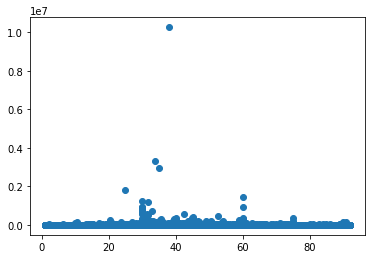

In [41]:
y = new_df['pledged']
x = new_df['duration']
plt.scatter(x,y)
plt.show()

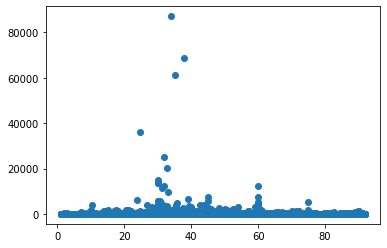

In [42]:
y = new_df['backers']
x = new_df['duration']
plt.scatter(x,y)
plt.show()

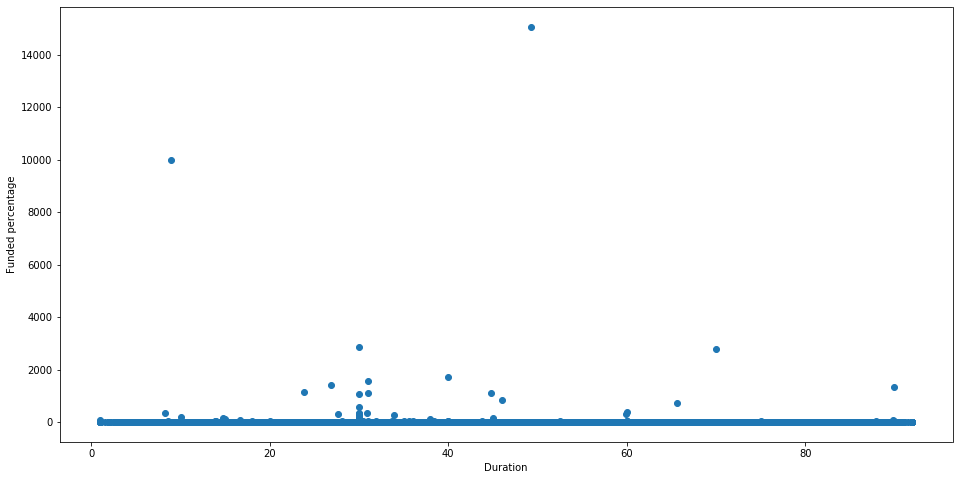

<Figure size 432x288 with 0 Axes>

In [43]:
y = new_df["funded percentage"]
x = new_df['duration']

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x, y)
ax.set_xlabel('Duration')
ax.set_ylabel('Funded percentage')
plt.show()
plt.savefig('duration_percfunded.jpg')

In [46]:
y = new_df[['duration',"status_dummy"]].groupby('status_dummy').mean()

In [49]:
y.barplot()

AttributeError: 'DataFrame' object has no attribute 'barplot'

## Check to see if project listing date is independent to month, day, year, and day of week
#### The Chi-Square test is a statistical hypothesis test to check independence of categorical variables. In this context, we use this test to see if projects are more or less likely to be posted in certain months, on certain days, or in particular years.

In [ ]:
month = new_df['project id'].groupby(new_df['month']).count()
stats.chisquare(month)

In [ ]:
month.plot.bar()

In [ ]:
day = new_df['project id'].groupby(new_df['day']).count()
stats.chisquare(day)

In [ ]:
day.plot.bar()

In [ ]:
year = new_df['project id'].groupby(new_df['year']).count()
stats.chisquare(year)

In [ ]:
year.plot.bar()

In [ ]:
day_of_week = new_df['project id'].groupby(new_df['day of week']).count()
stats.chisquare(day_of_week)

In [ ]:
day_of_week.plot.bar()

## Check for joint significance of month, day of week, and year 
#### The F-test tests multiple hypothesis. The null hypothesis is that all slopes/coefficients are zero. Unfortunately the data isn't normally distributed so a parametric test probably isn't appropriate.
##### Month dummies: Jointly significant; Reject Null
##### Year dummies: Jointly significant; Reject Null
##### Day of week dummies: Not Jointly Significant; Do not reject the null

In [ ]:
stats.f_oneway(new_df['status_dummy'][new_df['month'] == 1], 
               new_df['status_dummy'][new_df['month'] == 2], 
               new_df['status_dummy'][new_df['month'] == 3],
              new_df['status_dummy'][new_df['month'] == 4],
              new_df['status_dummy'][new_df['month'] == 5],
              new_df['status_dummy'][new_df['month'] == 6],
              new_df['status_dummy'][new_df['month'] == 7],
              new_df['status_dummy'][new_df['month'] == 8],
              new_df['status_dummy'][new_df['month'] == 9],
              new_df['status_dummy'][new_df['month'] == 10],
              new_df['status_dummy'][new_df['month'] == 11],
              new_df['status_dummy'][new_df['month'] == 12])

In [ ]:
stats.f_oneway(new_df['status_dummy'][new_df['year'] == 2009], 
               new_df['status_dummy'][new_df['year'] == 2010], 
               new_df['status_dummy'][new_df['year'] == 2011],
              new_df['status_dummy'][new_df['year'] == 2012])

In [ ]:
stats.f_oneway(new_df['status_dummy'][new_df['day of week'] == 0], 
               new_df['status_dummy'][new_df['day of week'] == 1], 
               new_df['status_dummy'][new_df['day of week'] == 2],
             new_df['status_dummy'][new_df['day of week'] == 3], 
              new_df['status_dummy'][new_df['day of week'] == 4],  
               new_df['status_dummy'][new_df['day of week'] == 5],
               new_df['status_dummy'][new_df['day of week'] == 6])

## Kruskal-Wallis Test
#### Kruskal-Wallis test is a nonparametric version of the ANOVA test ; Interprets the MEDIAN difference

In [ ]:
# compare samples
stat, p = kruskal(new_df['status_dummy'][new_df['month'] == 1], 
               new_df['status_dummy'][new_df['month'] == 2], 
               new_df['status_dummy'][new_df['month'] == 3],
              new_df['status_dummy'][new_df['month'] == 4],
              new_df['status_dummy'][new_df['month'] == 5],
              new_df['status_dummy'][new_df['month'] == 6],
              new_df['status_dummy'][new_df['month'] == 7],
              new_df['status_dummy'][new_df['month'] == 8],
              new_df['status_dummy'][new_df['month'] == 9],
              new_df['status_dummy'][new_df['month'] == 10],
              new_df['status_dummy'][new_df['month'] == 11],
              new_df['status_dummy'][new_df['month'] == 12])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.01
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

In [ ]:
# compare samples
stat, p = kruskal(new_df['status_dummy'][new_df['year'] == 2009], 
                new_df['status_dummy'][new_df['year'] == 2010],
                new_df['status_dummy'][new_df['year'] == 2011],
                new_df['status_dummy'][new_df['year'] == 2012])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.01
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

In [ ]:
# compare samples
stat, p = kruskal(new_df['status_dummy'][new_df['day of week'] == 0], 
               new_df['status_dummy'][new_df['day of week'] == 1], 
               new_df['status_dummy'][new_df['day of week'] == 2],
             new_df['status_dummy'][new_df['day of week'] == 3], 
              new_df['status_dummy'][new_df['day of week'] == 4],  
               new_df['status_dummy'][new_df['day of week'] == 5],
               new_df['status_dummy'][new_df['day of week'] == 6])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.01
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

## Dunn's Test
#### Dunn's test pinpoints which means are significantly different than the others
#### This section conducts the Dunn's test between 'status_dummy' and 'month', 'year', 'day of week' and 'year_month.'


In [ ]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='month', p_adjust='bonferroni')

In [ ]:
# 2010 and 2011 are significantly different 
# 2011 and 2012 are significantly different
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year', p_adjust='bonferroni')

In [ ]:
#Sunday, Monday, and Tuesday are the best days to post a new campaign
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='day of week', p_adjust='bonferroni')

In [ ]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_month', p_adjust='bonferroni')

In [ ]:
month = new_df['status_dummy'].groupby(new_df['month']).mean()
month.plot.bar()

In [ ]:
year = new_df['status_dummy'].groupby(new_df['year']).mean()
year.plot.bar()

In [ ]:
year_month = new_df['status_dummy'].groupby(new_df['year_month']).mean()
year_month.plot.bar()

In [ ]:
year_month = new_df['status_dummy'].groupby(new_df['day of week']).mean()
year_month.plot.bar()

## Conduct Logistic Regression

In [ ]:
new_df.columns

In [ ]:
X = new_df[['year_dummy', 'month_dummy', 'year_month', 'category_dummy', 'country_dummy']]
y = new_df['status_dummy']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
clf = LogisticRegression(C=0.5, penalty="l1", random_state=0).fit(X_train, y_train)

In [ ]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

In [ ]:
clf.predict_proba(X_test)

In [ ]:
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

## Gaussian Naive Bayes
### Gaussian Naive Bayes supports continuous valued features and models each as conforming to a Gaussian (normal) distribution.

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(gnb.score(X_train, y_train))
print(gnb.score(X_test, y_test))

## Random Forest

In [ ]:
random = RandomForestClassifier(random_state=0)
random.fit(X_train, y_train)
print(random.score(X_train, y_train))
print(random.score(X_test, y_test))

## Extreme Gradient Booster

In [ ]:
xgboost = XGBClassifier(learning_rate=.5)
eval_set = [(X_test, y_test)]
xgboost.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, early_stopping_rounds=50)
print(xgboost.score(X_train, y_train))
print(xgboost.score(X_test, y_test))

In [ ]:
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)
eval_set = [(X_test, y_test)]
param = {'learning_rate':0.5,'max_depth': 8, 'eval_metric':'auc',
         'objective': 'binary:logistic'}
num_round = 300
cv = xgb.cv(param, dtrain, num_round)

In [ ]:
cv.plot()

In [ ]:
cv[['test-auc-mean','train-auc-mean' ]].plot()

## Exploratory Analysis

In [ ]:
histogram = new_df['status_dummy'].groupby(new_df['status_dummy']).count()

In [ ]:
y = list(histogram.values)

In [ ]:
x = list(histogram.index)

In [ ]:
plt.hist(new_df['status_dummy'].T, bins=2)